In [2]:
import osmnx as ox
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import json
print("loaded")
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'lightblue', 'cyan', 'magenta', 'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'lightblue', 'cyan', 'magenta']
# secteurs à étudier
arrondissements = [
    'Ahuntsic-Cartierville',
    'Anjou',
    'Côte-des-Neiges–Notre-Dame-de-Grâce',
    'Lachine',
    'LaSalle',
    'Le Plateau-Mont-Royal',
    'Le Sud-Ouest',
    'L\'Île-Bizard–Sainte-Geneviève',
    'Mercier–Hochelaga-Maisonneuve',
    'Montréal-Nord',
    'Outremont',
    'Pierrefonds-Roxboro',
    'Rivière-des-Prairies–Pointe-aux-Trembles',
    'Rosemont–La Petite-Patrie',
    'Saint-Laurent',
    'Saint-Léonard',
    'Verdun',
    'Ville-Marie',
    'Villeray–Saint-Michel–Parc-Extension'
]

loaded


In [4]:
# get Osmnx graph from name of a sector
def get_graph(name):
    G = ox.graph_from_place(name, network_type='drive')
    G = ox.project_graph(G)
    return G

In [5]:
# you can call the getEulerienGraph with the name of the sector
# it will give you the eulerian path of this sector

def read_json(filename):
    with open(filename, "r") as file:
        data = json.loads(file.read())
    return data

def transform_to_tuples(list_of_lists):
    return [tuple(sub_list) for sub_list in list_of_lists]


def getEulerienGraph(name):
    i = arrondissements.index(name)
    print(arrondissements[i])
    chemin = read_json("../drone_scouting/paths.txt")
    return (transform_to_tuples(chemin[i]))
    


In [6]:
# get the eulerien graph of the sector of verdun
paths = getEulerienGraph("Outremont")
print("possède " + str(len(paths)) + " chemins")

Outremont
possède 479 chemins


In [23]:
# si le chemin n'existe pas dans le circuit non eulerien, on cherche le chemin entre les deux noeuds dans le graphe non eulerien

In [12]:
def is_in_graph(G, x, y):
    for (a, b, w) in G:
        if (x == a and y == b):
            return True
    return False


def getGraphFromList(list):
    G = []
    for i in range(0, len(list) - 1):
        G.append((list[i], list[i+1]))
    return G


def getAllNode(G):
    L = []
    for i in G:
        a,b,c = i
        L.append((a,b))
    return L

def is_in_graph2(G, x, y):
    for (a, b) in G:
        if (x == a and y == b):
            return True
    return False


# g is the graph from get_graph
# path is the list of path from lilian's part
def replace_nodes2(G, path):
    i = 0
    goodPath = []
    
    while(i < len(path)):
        a,b = path[i]
            
        # this path doesn't exist in our graph, 
        # we need to find shortest path 
        if(not is_in_graph(G.edges, a, b)):
            #print("this path doesn't exist in our graph", a,b)
            try:
                p = nx.shortest_path(G, source=a, target=b)
                l = getGraphFromList(p)
                goodPath += l
                if(is_in_graph(G.edges, b, a) and not is_in_graph(path, a, b) and not is_in_graph(goodPath, b, a)):
                    goodPath.append((b,a))
                    goodPath += l
                
            except:
                #print("this path doest exit :", a, b, is_in_graph(G.edges, b, a))
                goodPath.append((a,b))
        else:
            goodPath.append((a,b))
        i += 1
        
    return goodPath

In [21]:
def path_length(edges, g):
    dist_arr = []
    for u,v,k,obj in g.edges.data(keys=True):
        dist_arr.append((u,v,obj['length']))
    length = 0
    for u,v in edges:
        for u1,v1,l in dist_arr:
            if (u1 == u and v1 == v):
                length += l
                break
    return length

In [7]:
# pour obtenir le graphe orienté de la zone
g = get_graph("Outremont" + ", Montreal, Canada")

MultiDiGraph with 242 nodes and 609 edges


In [14]:

true_path2 = replace_nodes2(g, paths)
print("on passe par " + str(len(true_path2)) + " routes")

on passe par 760 routes


71967.43800000004
road not found 0


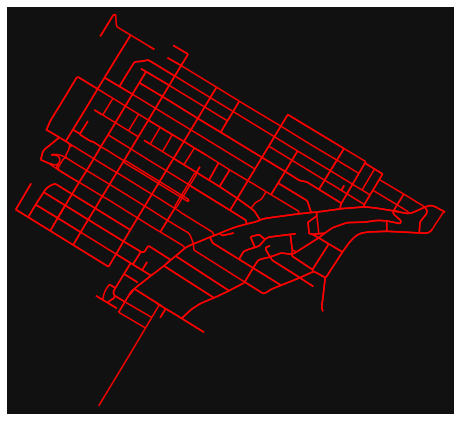

In [22]:
import matplotlib.pyplot as plt

def edge_colors(G, eulerian_edges):
    i = 0
    colors = []
    for u, v, _ in G.edges(keys=True):
        if (u, v) in eulerian_edges or (v, u) in eulerian_edges:
            colors.append('red')
        else:
            i +=1
            print("[" + str(u) + ", " + str(v) + "]")
            colors.append('blue')
    print("road not found",i)
    return colors

# Get the edges of the eulerian path
eulerian_edges = [(u, v) for u, v in true_path2]

distance = path_length(eulerian_edges, g)
print(distance)

# Set the colors of the edges
ec = edge_colors(g, true_path2)

fig, ax = ox.plot_graph(g, edge_color=ec, edge_linewidth=1.5, node_size=0)
plt.show()

In [10]:
print(path)

NameError: name 'path' is not defined